In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

In [70]:
file_path = r"C:\Users\sbtha\OneDrive\Documents\UOM_AI_SESSION\session_2\Housing.csv"
housing_data = pd.read_csv(file_path)

print("Dataset Shape:", housing_data.shape)
display(housing_data.head())

Dataset Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [71]:
print("Data Info:")
print(housing_data.info())

print("\nMissing Values:\n", housing_data.isnull().sum())
print("\nStatistical Summary:\n", housing_data.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None

Missing Values:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad  

In [72]:
binary_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for feature in binary_features:
    housing_data[feature] = housing_data[feature].map({'yes': 1, 'no': 0})

In [73]:
housing_data = pd.get_dummies(housing_data, columns=['furnishingstatus'], drop_first=True)

In [74]:
X_features = housing_data.drop(columns=['price'])
y_target = housing_data['price']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)


In [76]:
num_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [77]:
scaler_pipeline = Pipeline(steps=[('scale', StandardScaler())])
data_preprocessor = ColumnTransformer(transformers=[('num', scaler_pipeline, num_features)], remainder='passthrough')

In [78]:
from xgboost import XGBRegressor

linear_model = Pipeline(steps=[
    ('preprocess', data_preprocessor),
    ('regressor', LinearRegression())
])

try:
    xgb_regressor = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
except:
    xgb_regressor = RandomForestRegressor(n_estimators=200, random_state=42)

xgb_pipeline = Pipeline(steps=[
    ('preprocess', data_preprocessor),
    ('regressor', xgb_regressor)
])

In [79]:
linear_model.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [80]:
def model_evaluation(name, pipeline, X_train, X_test, y_train, y_test):
    preds = pipeline.predict(X_test)
    
    rmse_val = np.sqrt(mean_squared_error(y_test, preds))
    mae_val = mean_absolute_error(y_test, preds)
    r2_val = r2_score(y_test, preds)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse_scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train,
                                              scoring='neg_mean_squared_error', cv=kfold))
    
    print(f"\n===== {name} =====")
    print(f"Test RMSE: {rmse_val:.2f}")
    print(f"Test MAE : {mae_val:.2f}")
    print(f"Test R²  : {r2_val:.4f}")
    print(f"CV RMSE (mean ± std): {cv_rmse_scores.mean():.2f} ± {cv_rmse_scores.std():.2f}")
    
    return rmse_val

In [81]:
rmse_lr = model_evaluation("Linear Regression", linear_model, X_train, X_test, y_train, y_test)
rmse_xgb = model_evaluation("XGBoost", xgb_pipeline, X_train, X_test, y_train, y_test)

best_model = linear_model if rmse_lr < rmse_xgb else xgb_pipeline
best_name = "Linear Regression" if rmse_lr < rmse_xgb else "XGBoost"

print(f"\n✅ Best Performing Model: {best_name}")


===== Linear Regression =====
Test RMSE: 1324506.96
Test MAE : 970043.40
Test R²  : 0.6529
CV RMSE (mean ± std): 1023579.38 ± 48895.66

===== XGBoost =====
Test RMSE: 1455706.04
Test MAE : 1066423.88
Test R²  : 0.5808
CV RMSE (mean ± std): 1120524.36 ± 83243.49

✅ Best Performing Model: Linear Regression


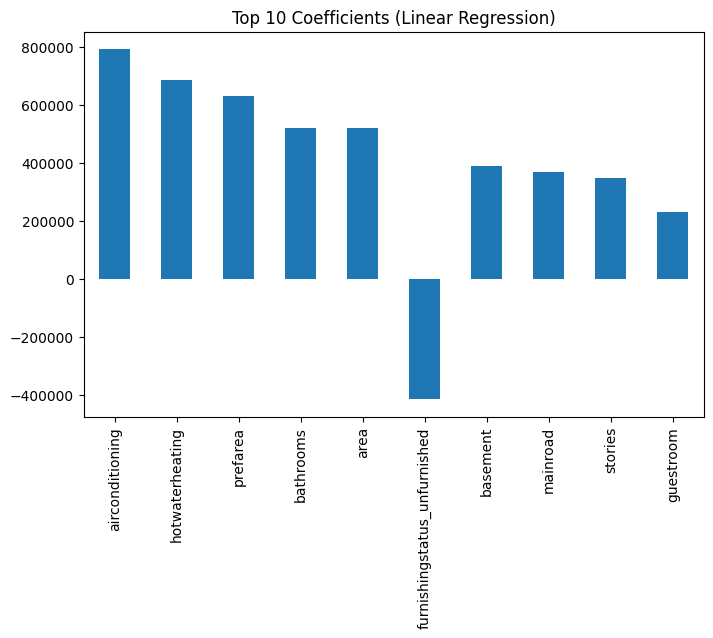

In [82]:
feature_list = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
other_features = [col for col in X_features.columns if col not in feature_list]
all_features = feature_list + other_features

final_model = best_model.named_steps['regressor']

if hasattr(final_model, 'feature_importances_'):
    importance_series = pd.Series(final_model.feature_importances_, index=all_features).sort_values(ascending=False)
    plt.figure(figsize=(8, 5))
    importance_series.head(10).plot(kind='bar')
    plt.title("Top 10 Feature Importances (XGBoost)")
    plt.show()

elif hasattr(final_model, 'coef_'):
    coef_series = pd.Series(final_model.coef_, index=all_features).sort_values(key=abs, ascending=False)
    plt.figure(figsize=(8, 5))
    coef_series.head(10).plot(kind='bar')
    plt.title("Top 10 Coefficients (Linear Regression)")
    plt.show()

In [83]:
with open("best_model.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

print("Model successfully saved as 'best_model.pkl'")

Model successfully saved as 'best_model.pkl'
